In [123]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import linalg as LA
import scipy
import math
import timeit
from scipy.stats import norm
from copy import copy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE 
from collections import Counter

# tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras import Model
from collections import Counter

In [124]:
# Loading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/itsamemonisha/MLProject/main/OnlineNewsPopularity.csv")
#rename shares column to remove leading space
df.rename(columns={" shares": "shares"}, inplace=True)
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


#Data Pre-processing

In [125]:
# check for missing values 
df.isnull().sum().sort_values(ascending=False)

url                           0
 weekday_is_monday            0
 weekday_is_wednesday         0
 weekday_is_thursday          0
 weekday_is_friday            0
                             ..
 kw_min_avg                   0
 kw_max_avg                   0
 kw_avg_avg                   0
 self_reference_min_shares    0
shares                        0
Length: 61, dtype: int64

In [126]:
# remove columns 
df.drop(labels=['url', ' timedelta'], axis = 1, inplace=True)
df.head(10)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
5,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,0.0,4.359459,...,0.136364,0.6,-0.195000,-0.400,-0.100000,0.642857,0.214286,0.142857,0.214286,855
6,8.0,960.0,0.418163,1.0,0.549834,21.0,20.0,20.0,0.0,4.654167,...,0.100000,1.0,-0.224479,-0.500,-0.050000,0.000000,0.000000,0.500000,0.000000,556
7,12.0,989.0,0.433574,1.0,0.572108,20.0,20.0,20.0,0.0,4.617796,...,0.100000,1.0,-0.242778,-0.500,-0.050000,1.000000,0.500000,0.500000,0.500000,891
8,11.0,97.0,0.670103,1.0,0.836735,2.0,0.0,0.0,0.0,4.855670,...,0.400000,0.8,-0.125000,-0.125,-0.125000,0.125000,0.000000,0.375000,0.000000,3600
9,10.0,231.0,0.636364,1.0,0.797101,4.0,1.0,1.0,1.0,5.090909,...,0.100000,0.5,-0.238095,-0.500,-0.100000,0.000000,0.000000,0.500000,0.000000,710


1. Missing Values:  No missing values were found in the dataset.
2. Feature Selection: The columns 'url' and 'timedelta' (which is the number of days between the article publication and the dataset acquisition) were dropped as they do not contribute to the task.

In [127]:
share_data = df['shares'] 
df['shares'].describe()
# check to see what numbers are needed to set thresholds 

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

In [128]:
# diving the number of shares into three categories:
# 'Poor': below 50%
# 'Average': between 50% and 75%
# 'Good': above 75%

# set threshhold values depending on the number of times an article has been shared 

share_label = list()
for share in share_data:
    if share < 1400:
        share_label.append('Poor')
    elif share >= 1400 and share <= 2800:
        share_label.append('Average')
    else:
        share_label.append('Good')

# add popularity based on set thresholds into the dataframe
df = pd.concat([df, pd.DataFrame(share_label, columns=['popularity'])], axis=1)
df

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,Poor
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,Poor
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,Average
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,Poor
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800,Average
39640,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,4.405488,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900,Average
39641,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,5.076923,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900,Average
39642,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,4.975073,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100,Poor


In [129]:
df['popularity'].value_counts()

Poor       18490
Average    11524
Good        9630
Name: popularity, dtype: int64

In [130]:
# checking correlation among variables 
col = "popularity"
df_discrete = df.loc[:, df.columns != col]
matrix = df_discrete.corr()
matrix
# checking variables that have a correlation above 80%
matrix[matrix > 0.8]
# n_unique_tokens, n_non_stop_words will be removed as they have a high correlation with the number of unique tokens
# number of non stop unique tokens is retained as they give us an idea of both non stop words as well as unique words 
df.drop(labels=[' n_unique_tokens', ' n_non_stop_words'], axis = 1, inplace=True)
df.head(10)

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,12.0,219.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,Poor
1,9.0,255.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,Poor
2,9.0,211.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,Average
3,9.0,531.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,Poor
4,13.0,1072.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,Poor
5,10.0,370.0,0.698198,2.0,2.0,0.0,0.0,4.359459,9.0,0.0,...,0.6,-0.195000,-0.400,-0.100000,0.642857,0.214286,0.142857,0.214286,855,Poor
6,8.0,960.0,0.549834,21.0,20.0,20.0,0.0,4.654167,10.0,1.0,...,1.0,-0.224479,-0.500,-0.050000,0.000000,0.000000,0.500000,0.000000,556,Poor
7,12.0,989.0,0.572108,20.0,20.0,20.0,0.0,4.617796,9.0,0.0,...,1.0,-0.242778,-0.500,-0.050000,1.000000,0.500000,0.500000,0.500000,891,Poor
8,11.0,97.0,0.836735,2.0,0.0,0.0,0.0,4.855670,7.0,0.0,...,0.8,-0.125000,-0.125,-0.125000,0.125000,0.000000,0.375000,0.000000,3600,Good
9,10.0,231.0,0.797101,4.0,1.0,1.0,1.0,5.090909,5.0,0.0,...,0.5,-0.238095,-0.500,-0.100000,0.000000,0.000000,0.500000,0.000000,710,Poor


#Data Visualization

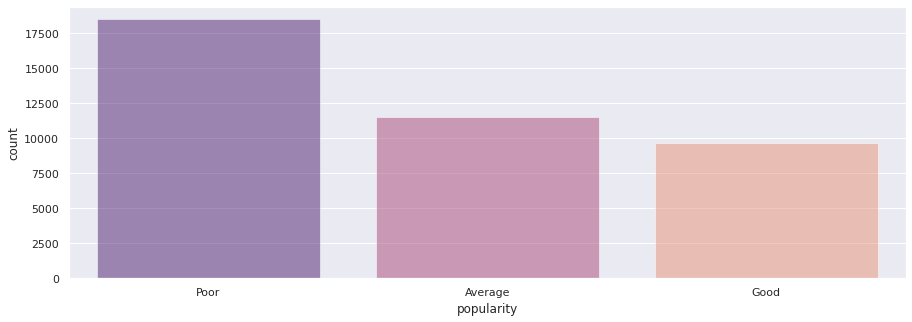

In [131]:
# general distribution of the popularity of articles 
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='popularity',data=df,alpha=0.5, palette = 'magma')

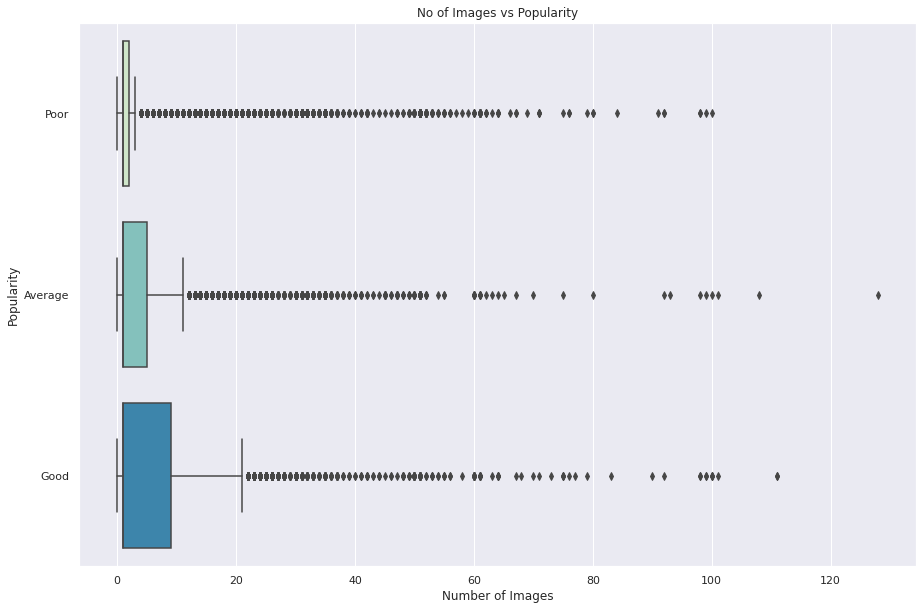

In [132]:
#Reading the dataset
# bill_dataframe = sns.load_dataset("tips")
#Creating boxplots
fig, axes = plt.subplots(figsize=(15,10))
ax = sns.boxplot(data=df, x=" num_imgs", y="popularity", palette="GnBu")
#Adding the aesthetics
plt.title('No of Images vs Popularity')
plt.xlabel('Number of Images')
plt.ylabel('Popularity') 
# Show the plot
plt.show()

In [133]:
# removing outliers
for x in ['shares']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

In [134]:
# check for missing values 
df.isnull().sum().sort_values(ascending=False)

shares                            4541
 n_tokens_title                      0
 global_rate_negative_words          0
 weekday_is_friday                   0
 weekday_is_saturday                 0
 weekday_is_sunday                   0
 is_weekend                          0
 LDA_00                              0
 LDA_01                              0
 LDA_02                              0
 LDA_03                              0
 LDA_04                              0
 global_subjectivity                 0
 global_sentiment_polarity           0
 global_rate_positive_words          0
 rate_positive_words                 0
 n_tokens_content                    0
 rate_negative_words                 0
 avg_positive_polarity               0
 min_positive_polarity               0
 max_positive_polarity               0
 avg_negative_polarity               0
 min_negative_polarity               0
 max_negative_polarity               0
 title_subjectivity                  0
 title_sentiment_polarity

In [135]:
df = df.dropna(axis = 0)

In [136]:
df

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,12.0,219.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,...,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593.0,Poor
1,9.0,255.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,...,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711.0,Poor
2,9.0,211.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,...,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500.0,Average
3,9.0,531.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,...,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200.0,Poor
4,13.0,1072.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,...,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505.0,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,...,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800.0,Average
39640,12.0,328.0,0.885057,9.0,7.0,3.0,48.0,4.405488,7.0,0.0,...,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900.0,Average
39641,10.0,442.0,0.644128,24.0,1.0,12.0,1.0,5.076923,8.0,0.0,...,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900.0,Average
39642,6.0,682.0,0.692661,10.0,1.0,1.0,0.0,4.975073,5.0,0.0,...,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100.0,Poor


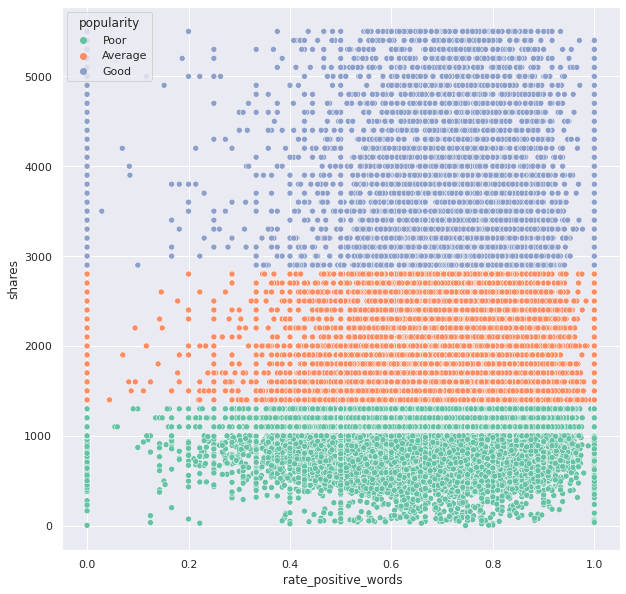

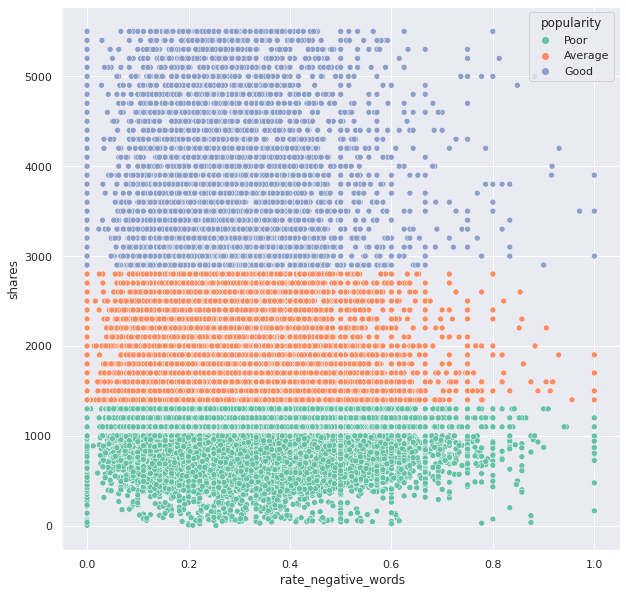

In [137]:
# distribution of popularity wrt to rate of positive words
temp_data = df[df['shares'] <= 200000]
# only keeping shares over 200000 helps visualize data better by not showing the few exceptions that are over this value
fig, axes = plt.subplots(figsize=(10,10))
sns.scatterplot(x=' rate_positive_words', y='shares', hue='popularity', data=temp_data, ax=axes, palette = 'Set2')

# distribution of popularity wrt to rate of negative words
temp_data = df[df['shares'] <= 200000]
fig, axes = plt.subplots(figsize=(10,10))
sns.scatterplot(x=' rate_negative_words', y='shares', hue='popularity', data=temp_data, ax=axes, palette = 'Set2')

In [138]:
# popularity based on category 
# Merging the different categories into one column
merge = df[[' data_channel_is_lifestyle',' data_channel_is_entertainment' ,' data_channel_is_bus',
                        ' data_channel_is_socmed' ,' data_channel_is_tech',' data_channel_is_world' ]]
#logic to merge data channel
cats =[]
for r in list(range(merge.shape[0])):
    if (((merge.iloc[r,0])==0) and ((merge.iloc[r,1])==0) and ((merge.iloc[r,2])==0) and ((merge.iloc[r,3])==0) and 
        ((merge.iloc[r,4])==0) and ((merge.iloc[r,5])==0)):
        cats.append('Others')
    for c in list(range(merge.shape[1])):
        if ((c==0) and (merge.iloc[r,c])==1):
            cats.append('Lifestyle')
        elif ((c==1) and (merge.iloc[r,c])==1):
            cats.append('Entertainment')
        elif ((c==2) and (merge.iloc[r,c])==1):
            cats.append('Business')
        elif ((c==3) and (merge.iloc[r,c])==1):
            cats.append('Social Media')
        elif ((c==4) and (merge.iloc[r,c])==1):
            cats.append('Tech')
        elif ((c==5) and (merge.iloc[r,c])==1):
            cats.append('World')

df.insert(loc = 1, column ='category', value = cats)

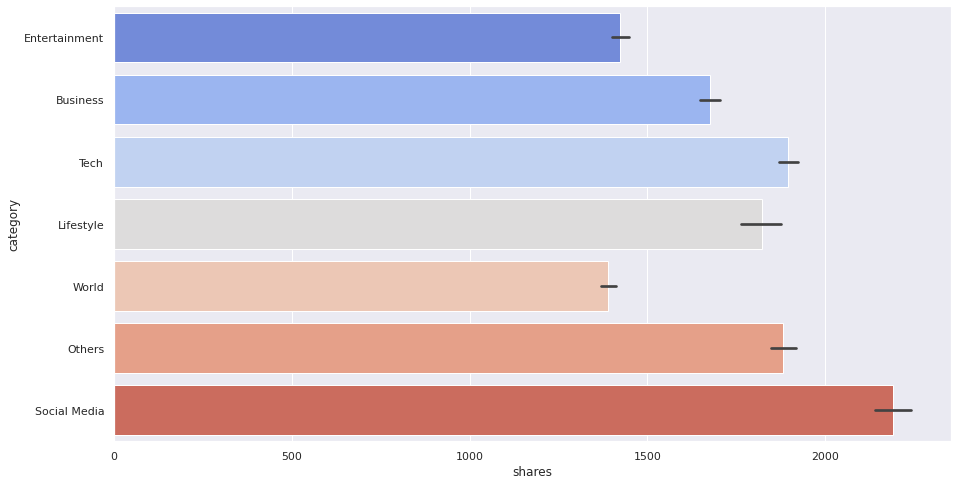

In [139]:
sns.set(rc={'figure.figsize':(15,8)})

# order = ['Others', 'second', 'third']
ax = sns.barplot(x = "shares", y = "category", data=df, palette = 'coolwarm')

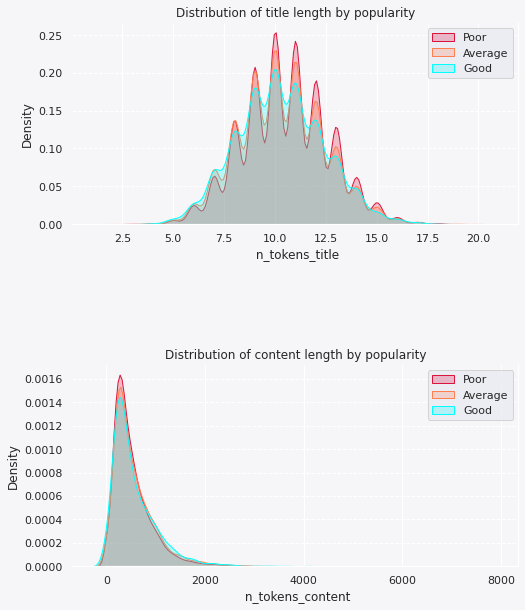

In [140]:
df_tmp = df[[' n_tokens_title', ' n_tokens_content', 'shares','popularity']]
fig = plt.figure(figsize=(8,10))
gs = fig.add_gridspec(2,1)
gs.update(wspace=.7, hspace=.7)

# adding figures
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])

axes=[ax0,ax1]
background_color = '#f6f5f7'
for i in axes:
    i.set_facecolor(background_color)
fig.patch.set_facecolor(background_color) 

sns.kdeplot(ax=ax0,x=df_tmp.loc[df_tmp['popularity']=='Poor'][' n_tokens_title'],color='crimson',label='Poor',shade=True).set(title='Distribution of title length by popularity')
sns.kdeplot(ax=ax0,x=df_tmp.loc[df_tmp['popularity']=='Average'][' n_tokens_title'],color='coral',label='Average',shade=True)
sns.kdeplot(ax=ax0,x=df_tmp.loc[df_tmp['popularity']=='Good'][' n_tokens_title'],color='#00FFFF',label='Good',shade=True)

ax0.legend(loc = 'upper right')
ax0.grid(linestyle='--', axis='y')

sns.kdeplot(ax=ax1,x=df_tmp.loc[df_tmp['popularity']=='Poor'][' n_tokens_content'],color='crimson',label='Poor',shade=True).set(title='Distribution of content length by popularity')
sns.kdeplot(ax=ax1,x=df_tmp.loc[df_tmp['popularity']=='Average'][' n_tokens_content'],color='coral',label='Average',shade=True)
sns.kdeplot(ax=ax1,x=df_tmp.loc[df_tmp['popularity']=='Good'][' n_tokens_content'],color='#00FFFF',label='Good',shade=True)

ax1.legend(loc = 'upper right')
ax1.grid(linestyle='--', axis='y')

for i in ["top","left"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)

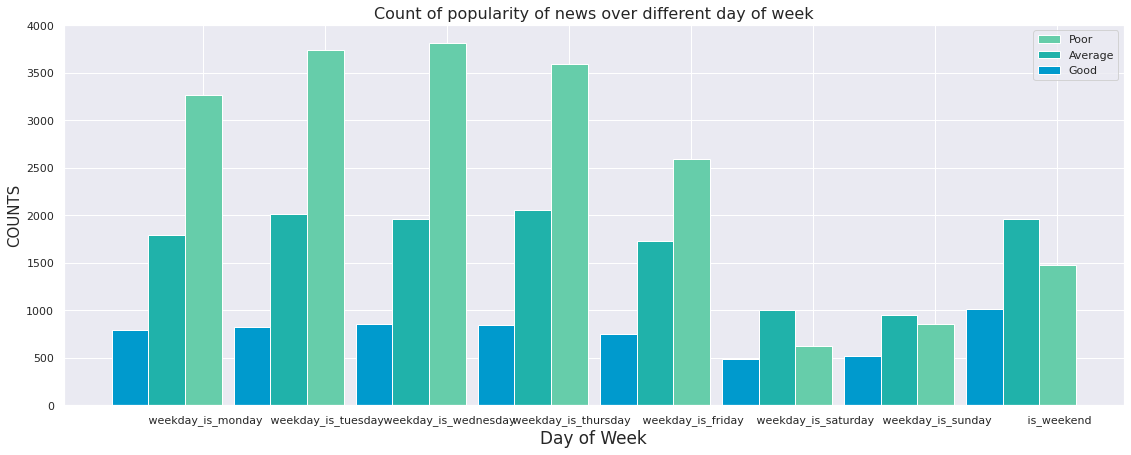

In [141]:
df_week = df.columns.values[28:36]
Poor_day = df[df['popularity'] == 'Poor'][df_week].sum().values
Average_day = df[df['popularity'] == 'Average'][df_week].sum().values
Good_day = df[df['popularity'] == 'Good'][df_week].sum().values

fig = plt.figure(figsize = (19,7))
plt.title("Count of popularity of news over different day of week", fontsize = 16)

plt.bar(np.arange(len(df_week)),Poor_day,width=0.3,align='center',color='#66CDAA',label='Poor')
plt.bar(np.arange(len(df_week))-0.3,Average_day,width=0.3,align='center',color='#20B2AA',label='Average')
plt.bar(np.arange(len(df_week))-0.6,Good_day,width=0.3,align='center',color='#009ACD',label='Good')

plt.xticks(np.arange(len(df_week)),df_week)
plt.ylabel('COUNTS',fontsize=15)
plt.xlabel('Day of Week',fontsize=17)
plt.legend(loc = 'upper right')

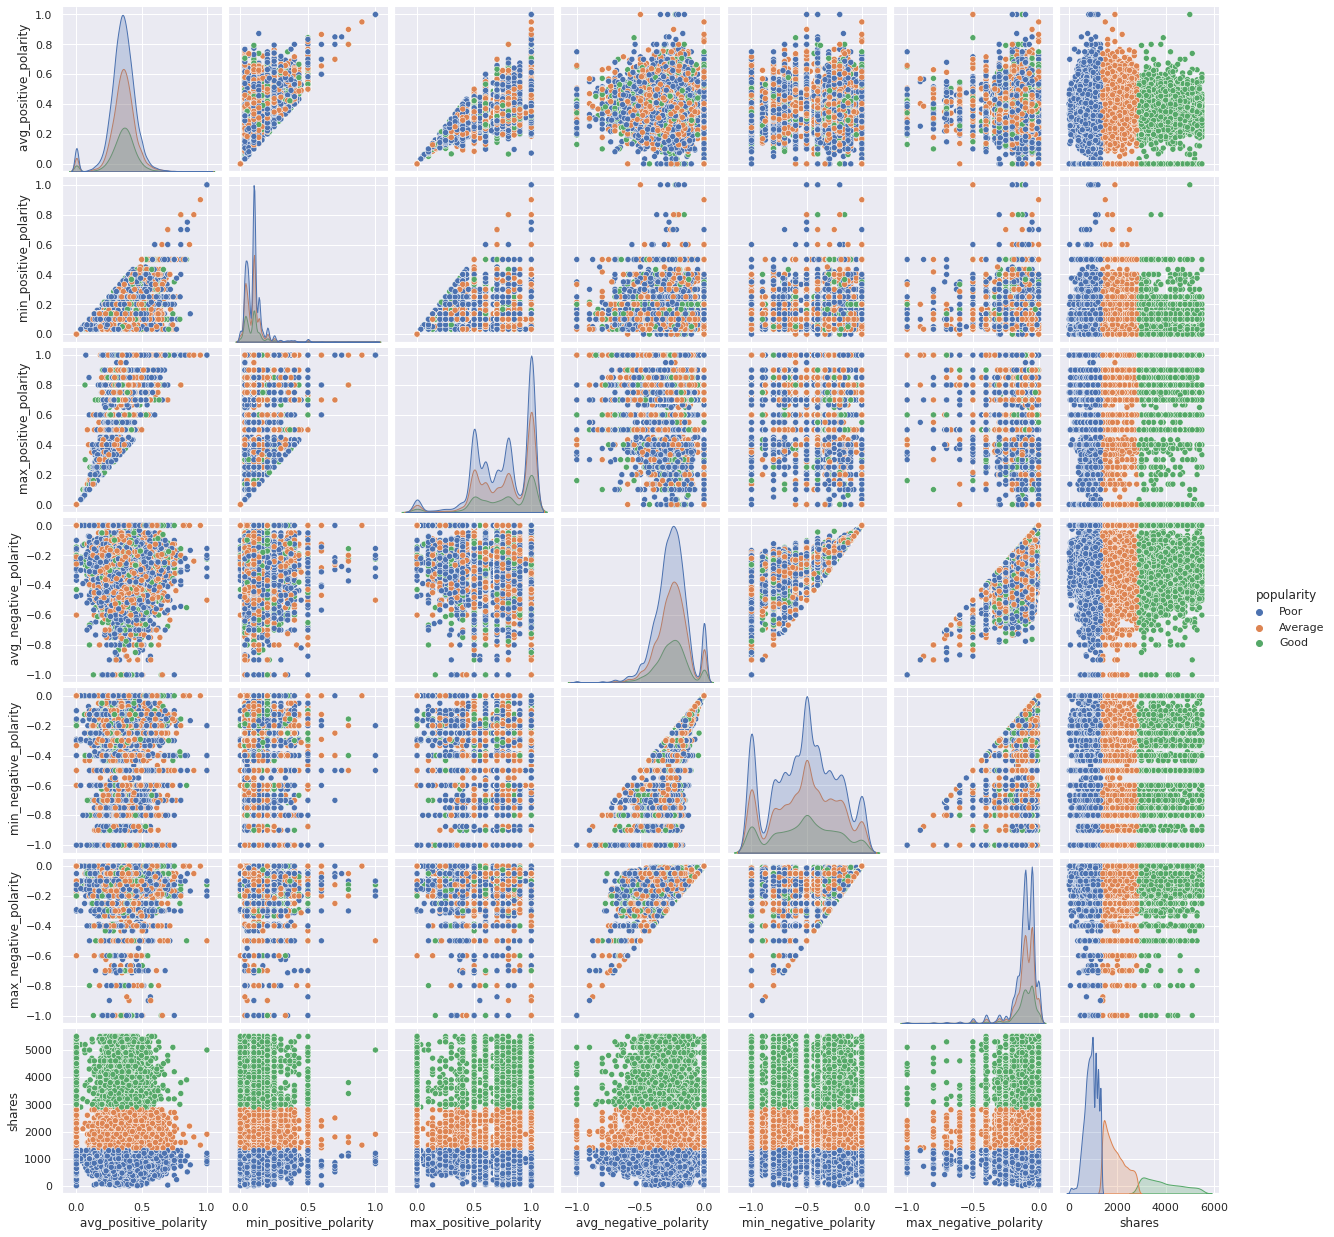

In [142]:
# pair plot for the terms
kw_cols = [' avg_positive_polarity', ' min_positive_polarity', ' max_positive_polarity', ' avg_negative_polarity', ' min_negative_polarity', ' max_negative_polarity', 'shares']
sns.pairplot(df, vars=kw_cols, hue='popularity', diag_kind='kde')

In [143]:
# sns colors: 
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma

#Dimensionality Reduction

In [144]:
df = df.drop(['category'], axis=1)
# looking at the number of each popularity type in the visualizations we see a clear class imbalance, we use SMOTE to try and correct this
oversample = SMOTE()
X = df.iloc[:,:-1]
y = df['popularity']
X, y = oversample.fit_resample(X, y)

df = copy(X)
df['popularity'] = y

df['popularity'].value_counts()

Poor       18490
Average    18490
Good       18490
Name: popularity, dtype: int64

In [145]:
# variables that contain binary values are dropped for scaling
binary = df[[' data_channel_is_lifestyle', ' data_channel_is_entertainment',
            ' data_channel_is_bus', ' data_channel_is_socmed',
            ' data_channel_is_tech', ' data_channel_is_world',
            ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
            ' weekday_is_thursday',' weekday_is_friday', ' weekday_is_saturday', 
            ' weekday_is_sunday', ' is_weekend', 'popularity']]
df_to_scale = copy(df)
df_to_scale = df_to_scale.drop(binary, axis=1)

In [146]:
# storing a record of only numerical values without shares and popularity
df_noncat = copy(df)
df_noncat = df_noncat.drop(['shares', 'popularity'], axis = 1)

In [147]:
# Standardize Dataset
class StandardScaler:
    def __init__(self):
        pass

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.scale = np.std(X - self.mean, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean) / self.scale

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [148]:
df_X = df_to_scale.iloc[:,:-1] # without shares
scaler = StandardScaler()
scaled = scaler.fit_transform(df_X)

In [149]:
scaled

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.824921,-0.752861,1.000598,-0.657062,-0.362858,-0.453187,-0.320938,0.165243,-1.232219,-0.391116,...,0.257759,0.092186,-0.251345,-0.771644,-0.299355,-1.055442,0.723088,-1.064706,-1.934206,0.152966
1,-0.684613,-0.671209,0.837637,-0.752546,-0.632594,-0.453187,-0.320938,0.461010,-1.778645,-0.391116,...,-0.687252,-0.917082,-0.251345,1.167016,1.446285,0.078212,-0.925021,-0.303733,0.888934,-0.736720
2,-0.684613,-0.771005,-0.052878,-0.752546,-0.632594,-0.453187,-0.320938,-0.198509,-0.685793,-0.391116,...,1.465242,0.092186,1.039155,-1.749707,-1.034361,-0.299673,-0.925021,-0.303733,0.888934,-0.736720
3,-0.684613,-0.045214,-0.040577,-0.179643,-0.902330,-0.453187,-0.320938,-0.183893,-0.139367,-0.391116,...,0.333268,0.642696,0.178822,-0.936771,-0.299355,-0.677558,-0.925021,-0.303733,0.888934,-0.736720
4,1.328100,1.181826,-0.907900,0.775194,4.222656,2.002114,-0.320938,0.168375,-0.139367,-0.391116,...,0.592516,-0.917082,1.039155,0.316585,0.068149,0.645038,0.573260,0.249703,-1.677557,-0.089676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,0.216992,-0.504575,0.369876,-0.211589,0.345074,-0.453187,-0.320938,0.150362,0.088141,-0.334796,...,-1.202750,-0.917082,-0.843024,-0.066535,0.566121,-1.200836,0.466987,0.553234,-1.197459,0.265196
55466,0.494213,-0.084533,0.422532,1.978697,-0.063575,2.782954,-0.291396,0.206353,0.953484,-0.405196,...,1.552369,0.471838,1.039155,-0.364505,-0.052620,-0.454560,2.010129,1.503245,0.888934,1.375892
55467,0.069495,0.024062,-2.052556,-0.501620,-0.902330,-0.453187,-0.051252,-2.431509,0.133130,-0.405196,...,-1.095324,-0.948374,-0.572562,0.982232,0.756615,0.502961,0.001231,-1.130569,0.360058,0.229969
55468,0.498132,1.600487,-0.254998,-0.086625,-0.902330,-0.453187,-0.051252,-0.517067,-1.778645,-0.405196,...,1.059732,-0.541864,1.039155,-1.378341,-1.769367,0.032196,0.987982,0.946825,-0.563708,0.725358


# Feature Selection

In [150]:
df

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,12.000000,219.000000,0.815385,4.000000,2.000000,1.00000,0.00000,4.680365,5.000000,0.00000,...,0.700000,-0.350000,-0.600000,-0.200000,0.500000,-0.187500,0.000000,0.187500,593.000000,Poor
1,9.000000,255.000000,0.791946,3.000000,1.000000,1.00000,0.00000,4.913725,4.000000,0.00000,...,0.700000,-0.118750,-0.125000,-0.100000,0.000000,0.000000,0.500000,0.000000,711.000000,Poor
2,9.000000,211.000000,0.663866,3.000000,1.000000,1.00000,0.00000,4.393365,6.000000,0.00000,...,1.000000,-0.466667,-0.800000,-0.133333,0.000000,0.000000,0.500000,0.000000,1500.000000,Average
3,9.000000,531.000000,0.665635,9.000000,0.000000,1.00000,0.00000,4.404896,7.000000,0.00000,...,0.800000,-0.369697,-0.600000,-0.166667,0.000000,0.000000,0.500000,0.000000,1200.000000,Poor
4,13.000000,1072.000000,0.540890,19.000000,19.000000,20.00000,0.00000,4.682836,7.000000,0.00000,...,1.000000,-0.220192,-0.500000,-0.050000,0.454545,0.136364,0.045455,0.136364,505.000000,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,10.791821,328.468778,0.724669,8.665432,4.624537,1.00000,0.00000,4.668624,7.416358,0.00000,...,0.562454,-0.265892,-0.364498,-0.212825,0.422305,0.211152,0.130484,0.211152,3583.271578,Good
55466,11.342760,513.664586,0.732243,31.604260,3.109540,26.04242,0.10954,4.712801,9.000000,0.89046,...,1.000000,-0.301435,-0.532862,-0.146996,0.890460,0.445230,0.500000,0.445230,4056.184006,Good
55467,10.498691,561.543916,0.376256,5.627946,0.000000,1.00000,1.00000,2.631528,7.498691,0.00000,...,0.625327,-0.140792,-0.312664,-0.062533,0.281005,-0.203728,0.406332,0.203728,4362.532730,Good
55468,11.350549,1256.586521,0.634795,9.974176,0.000000,1.00000,1.00000,4.142023,4.000000,0.00000,...,1.000000,-0.422369,-1.000000,-0.104059,0.580363,0.308131,0.242726,0.308131,3143.544103,Good


# Mutual Information

In [151]:
from sklearn.feature_selection import mutual_info_regression

In [152]:
m_values = mutual_info_regression(df.iloc[:,:-2], df['shares'])
mi = pd.DataFrame({'Variable': df.iloc[:,:-2].columns, 'Mutual Information': m_values })
mi = mi.sort_values(by = 'Mutual Information', ascending = False)
mi = mi.head(20)
mi

,Variable,Mutual Information
0,n_tokens_title,0.328668
3,num_hrefs,0.309503
50,min_negative_polarity,0.304286
4,num_self_hrefs,0.286694
51,max_negative_polarity,0.285502
48,max_positive_polarity,0.270698
47,min_positive_polarity,0.265141
8,num_keywords,0.260914
5,num_imgs,0.234938
52,title_subjectivity,0.180857


# Fisher Scores

In [153]:
# sending non categorial values without shares for LDA
training_set = df_noncat

# getting popularity labels
label_set = df.iloc[:, (df.shape[1]-1):].values

In [154]:
# helper function for evalating the fisher ndex
def fisher_index_calc(trainingSet, labelSet):
    (dim1_T, dim2_T) = trainingSet.shape
    (dim1_L, dim2_L) = labelSet.shape
    fisher_ratios = np.zeros((1, dim2_T), dtype=float).flatten()

    if dim1_L != dim1_T:
        return fisher_ratios

    train1 = pd.DataFrame(trainingSet)
    label1 = pd.DataFrame(labelSet, columns=['LABEL'])
    grouped = pd.concat([train1, label1], axis=1)

    # fetch the number of classes
    (no_classes, demo) = grouped.groupby('LABEL').count()[[0]].shape

    # loop through all features
    for j in range(dim2_T):
        # the variance of the feature j
        j_variance = np.var(trainingSet[:,j])
        j_mean = np.mean(trainingSet[:,j])
        j_summation = 0
        for k in range(no_classes):
            output = grouped.groupby('LABEL').count()[[j]]
            k_feature_count = output.iloc[k,0]
            # mean for class k of feature j
            output = grouped.groupby('LABEL').mean()[[j]]
            k_feature_mean = output.iloc[k,0]
            currentSum = k_feature_count * np.square((k_feature_mean - j_mean))
            j_summation = j_summation + currentSum
        fisher_ratios[j] = round(j_summation / np.square(j_variance),4)

    return fisher_ratios

In [155]:
# calculates the fisher score of the features
fisher_scores = fisher_index_calc(training_set.values, label_set)

LDA = pd.DataFrame({'Fisher Ratio For All Features': fisher_scores})

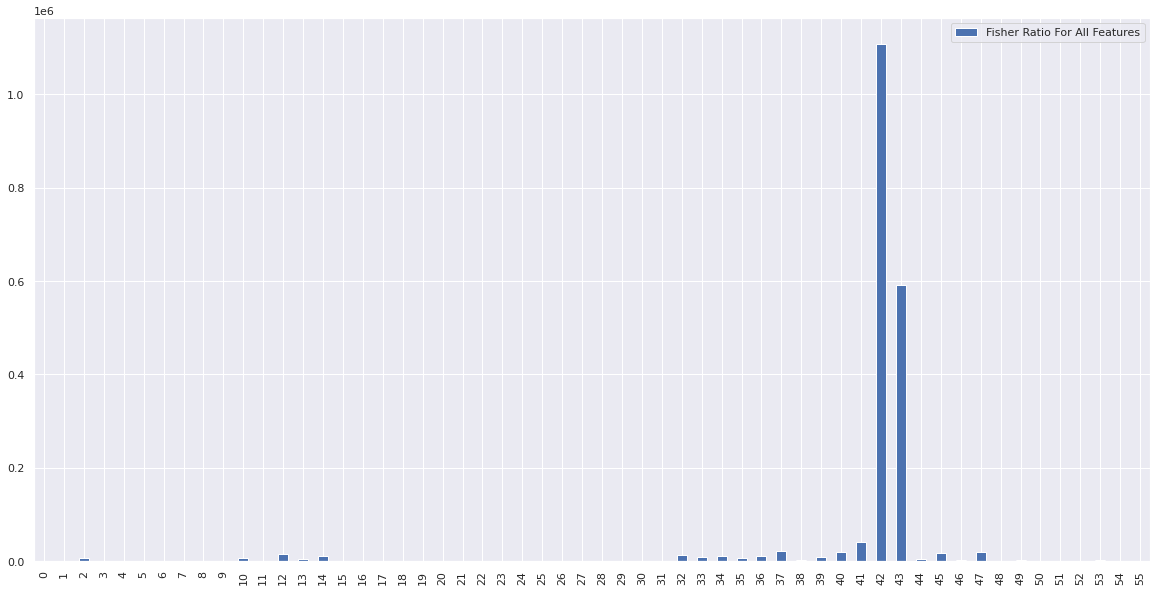

In [156]:
# plot the fisher analysis score
ax = LDA.plot.bar(figsize=(20,10))
plt.show()

In [157]:
display = pd.DataFrame({'Variable' :df_noncat.columns, 'fisher score' :fisher_scores})
top = display.sort_values(by = 'fisher score',
                          ascending = False)
top = top.head(20)
top

,Variable,fisher score
42,global_rate_positive_words,1.108217e+06
43,global_rate_negative_words,5.904275e+05
41,global_sentiment_polarity,4.202311e+04
37,LDA_02,2.109678e+04
40,global_subjectivity,2.040552e+04
47,min_positive_polarity,1.943085e+04
45,rate_negative_words,1.685455e+04
12,data_channel_is_socmed,1.572326e+04
32,weekday_is_saturday,1.264673e+04
36,LDA_01,1.206124e+04


In [158]:
s1 = pd.merge(top, mi, how='inner', on=['Variable'])
s1

,Variable,fisher score,Mutual Information
0,LDA_02,21096.7754,0.167399
1,min_positive_polarity,19430.8489,0.265141
2,rate_negative_words,16854.5540,0.129771
3,LDA_01,12061.2395,0.149592
4,LDA_00,6664.1884,0.148558


In [159]:
#np.array(mi['Variable'])

In [160]:
df_reg = df[[' LDA_02', ' min_positive_polarity', ' LDA_01', ' LDA_04',
             ' LDA_00', ' global_rate_positive_words', ' global_rate_negative_words',
             ' global_sentiment_polarity', ' global_subjectivity',
             ' data_channel_is_socmed', ' n_tokens_title', ' num_hrefs', ' num_self_hrefs',
             ' min_negative_polarity', ' max_negative_polarity' ]]
# we select features based on the results of mutual information and fisher scores, the variables picked include common features among the two 
# as well as the top 5 features from each of the two results that are not common 

# PCA

In [161]:
class PCA:

  def __init__(self) -> None:
      pass

  def eig_sorted(self, X):
    self.X_mean = X - np.mean(X, axis = 0)
    cov_mat = np.cov(self.X_mean, rowvar = False)
    eig_val, eig_vec = LA.eig(cov_mat)
    self.eig_val, eig_vec = zip(*sorted(zip(list(eig_val), list(eig_vec.T)),key=lambda x: x[0], reverse=True))
    self.eig_vec = np.array(eig_vec).T
    # calcualtive cumulative variance captured 
    var = np.abs(self.eig_val)/X.shape[1]
    cs = 0
    temp_var = var
    csum = []

    for i in range(len(temp_var)):
      next = cs+temp_var[i]
      csum.append(round(next,3)*100)
      cs = next
    vals = pd.DataFrame({'Eigen Values':eig_val, 'Eigen Vectors': eig_vec, 'Cumulative Variance (%)':csum})
   
    plt.plot(csum)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative Variance')
    plt.show()

    return vals[vals['Cumulative Variance (%)']<=95] #atleast 95% 


  def PC_plot(self):

    plt.plot(np.abs(self.eig_val)/np.sum(self.eig_val) )
    plt.xlabel('Number of components')
    plt.ylabel('Significance')
    plt.show()

  def pca_func(self, X, n_components):
    eigenvector_sub = self.eig_vec[:,0:n_components]

    X_sub = np.dot(eigenvector_sub.transpose(),self.X_mean.transpose()).transpose()
    
    colnames=["PC"+str(i) for i in range(n_components)]
    PC_df = pd.DataFrame(X_sub, columns = colnames)

    return PC_df

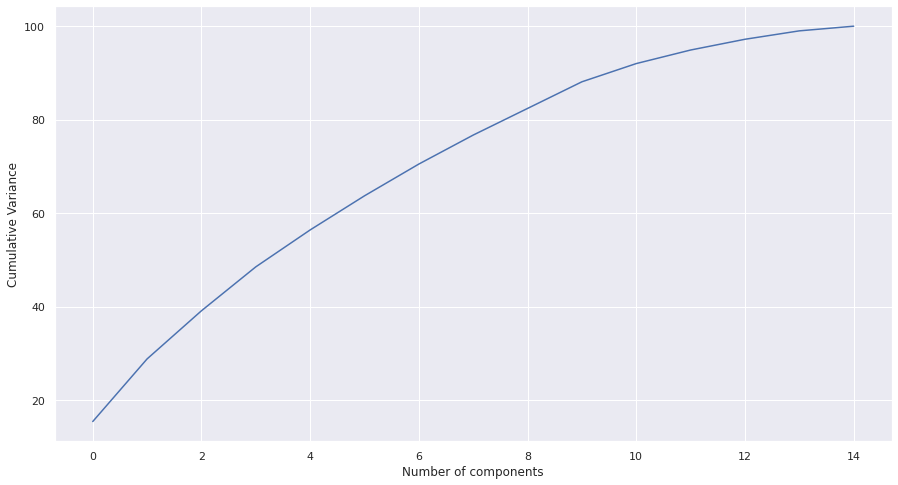

,Eigen Values,Eigen Vectors,Cumulative Variance (%)
0,2.310037,"[-0.31226688843973005, 0.05013312277464323, 0....",15.4
1,2.014001,"[0.11590015717427762, -0.005991764571970036, 0...",28.8
2,1.534937,"[-0.136161145071385, 0.4954922329688525, 0.295...",39.1
3,1.419037,"[0.11208552665674341, 0.06665905014332424, -0....",48.5
4,0.154046,"[-0.3262664738547032, -0.33020258924117984, 0....",56.4
5,0.273056,"[-0.36979673453258544, -0.2167048571168107, -0...",63.7
6,0.338694,"[-0.5009782609264296, 0.2935126564838408, 0.23...",70.5
7,0.438280,"[0.2538387190479157, 0.02664778671745744, 0.32...",76.7
8,0.586055,"[0.12650567561530757, -0.2057045499315775, 0.2...",82.4
9,1.179946,"[0.01359520447440426, 0.5454501732526366, -0.0...",88.1


In [162]:
# perform pca on scaled dataset
pca = PCA()
pca.eig_sorted(scaler.fit_transform(df_reg))

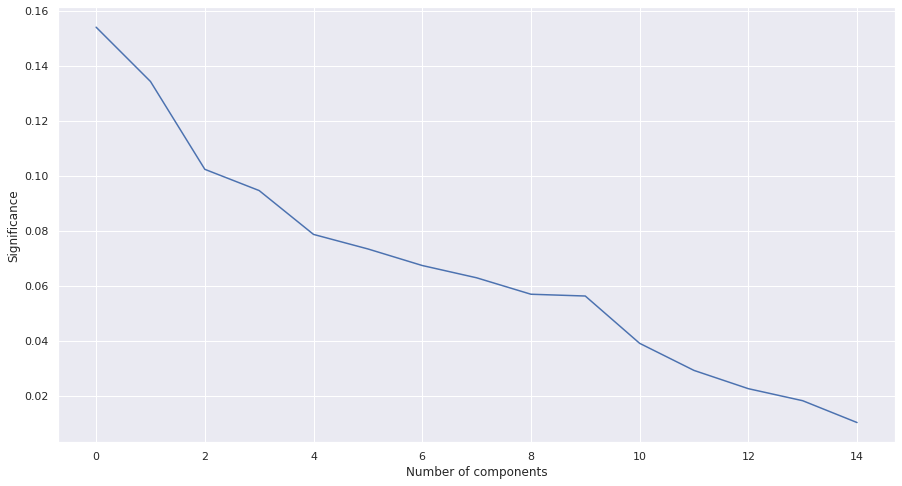

In [163]:
pca.PC_plot()

In [164]:
pop = np.array(df['popularity'])

In [165]:
PCs = pca.pca_func(scaler.fit_transform(df_reg),12)

In [166]:
PCs['popularity'] = pop
PCs['shares'] = df['shares']
PCs

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,popularity,shares
0,0.486431,0.299925,1.112601,-1.734108,0.759214,-0.355155,0.187419,-0.919959,-0.101419,-0.500346,0.202036,0.464546,Poor,593.000000
1,-0.304060,-1.814769,-0.829103,-2.105391,0.122425,0.987794,0.114368,-0.078585,-1.071435,-0.482224,0.713857,-0.642598,Poor,711.000000
2,2.973542,-0.751588,1.253882,0.493506,-0.854471,0.960488,-1.195141,0.147027,-0.188901,-0.523716,-0.769422,1.481302,Average,1500.000000
3,-0.683894,0.851293,1.323500,-0.601925,-0.043083,-0.823076,-0.178925,1.447396,0.259946,-0.461608,0.052041,-0.117291,Poor,1200.000000
4,3.437672,-0.485908,-1.676506,3.397828,1.646210,0.149176,-0.485936,-1.453090,0.722406,0.363013,1.978683,0.237046,Poor,505.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55465,0.642357,-1.020542,-1.936839,-2.248827,-1.349015,-0.571514,1.181956,-1.157065,2.494476,0.272175,-0.490242,0.151988,Good,3583.271578
55466,0.767382,0.301387,-0.084775,0.488190,0.032229,-1.071317,0.591808,-0.701232,-0.972271,0.016119,-1.164656,-0.666277,Good,4056.184006
55467,-1.602557,-1.481218,-0.055817,0.789950,0.616010,1.058551,0.240378,-0.228703,0.206088,-0.582336,-0.980994,-0.033120,Good,4362.532730
55468,1.010307,1.375390,-0.408048,-2.232933,-0.165365,1.071480,-0.861572,-1.122493,-1.216598,-0.184473,-0.309671,0.563168,Good,3143.544103


[(-5.476260086789431, 10.0)]

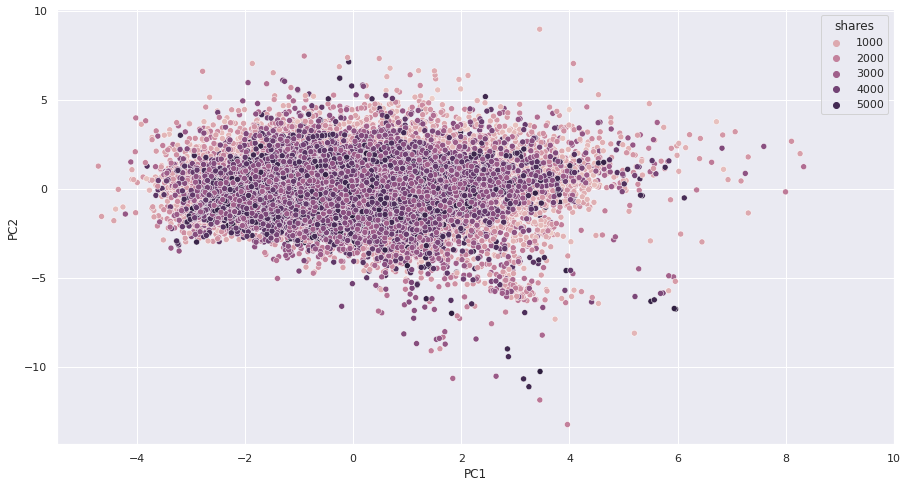

In [167]:
g = sns.scatterplot(data = PCs, x = "PC1", y = "PC2", hue = "shares")
g.set(xlim=(None, 10))

#Regression Models

In [168]:
# with scaling
X = scaler.fit_transform(df_reg)
Y = df[['shares','popularity']]
# Splitting dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.25, random_state = 0 )

In [169]:
X_test.shape[0]

13868

In [170]:
X_pca = PCs.iloc[:,:-2]
# X_pca = PCs.iloc[:,:-2]
Y_pca = PCs[['shares','popularity']]
# Splitting dataset into train and test set
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( X_pca, Y_pca, test_size = 0.25, random_state = 0 )

In [171]:
X_test_pca.shape[0]

13868

In [172]:
# we sample data here due to the time complexity of some models
sample = copy(X)
sample['shares'] = Y['shares']
sample['popularity'] = Y['popularity']

sample = sample.groupby('popularity').sample(300, random_state=3)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample.iloc[:,:-2], 
                                                                                sample[['shares','popularity']], 
                                                                                test_size = 0.25, random_state = 0 )

#for knn
sample_knn = sample.groupby('popularity').sample(100, random_state=3)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(sample_knn.iloc[:,:-2], 
                                                                    sample_knn[['shares','popularity']], 
                                                                    test_size = 0.25, random_state = 0 )

In [173]:
X_test_sample.shape[0]

225

# Linear Regression


In [ ]:
class LinearRegression() :
      
    def __init__( self, learning_rate, iterations ) :
          
        self.learning_rate = learning_rate         
        self.iterations = iterations


    def fit( self, X, Y ) :        
        # no_of_training_examples, no_of_features       
        self.m, self.n = X.shape        
        # weight initialization       
        self.W = np.zeros( self.n )       
        self.b = 0     
        self.X = X       
        self.Y = Y
    
        # gradient descent learning                 
        for i in range( self.iterations ) :            
            self.update_weights()
              
        return self
      
    # function to update weights in gradient descent
      
    def update_weights( self ) :
             
        Y_pred = self.predict( self.X )          
        # calculate gradients       
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.m      
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
          
        # update weights      
        self.W = self.W - self.learning_rate * dW   
        self.b = self.b - self.learning_rate * db
          
        return self
      
    # Hypothetical function  h( x ) 
      
    def predict( self, X ) :
      
        return X.dot( self.W ) + self.b

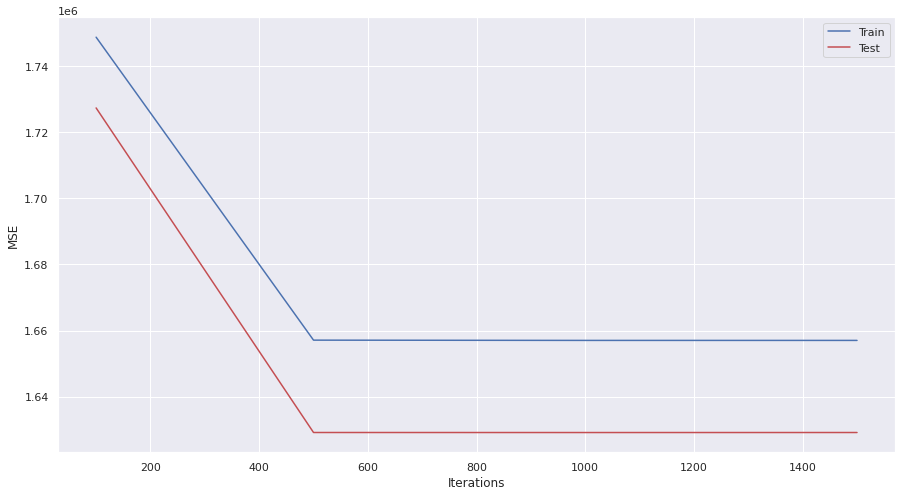

In [ ]:
# finding the best epoch size
mse_test = []
mse_train = []
rates = [100,500,1000,1500]
for i in rates:
  model = LinearRegression( iterations = i, learning_rate = 0.01)

  model.fit( X_train, y_train['shares'] )
  Y_pred_train = model.predict( X_train)
  Y_pred_test = model.predict( X_test)
  mse_test.append(mean_squared_error(y_test['shares'], Y_pred_test))
  mse_train.append(mean_squared_error(y_train['shares'], Y_pred_train))

xaxis = rates
# Plot a simple line chart
plt.plot(xaxis, mse_train, 'b', label = "Train")
# Plot another line on the same chart/graph
plt.plot(xaxis, mse_test, 'r', label = "Test")

plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.legend()

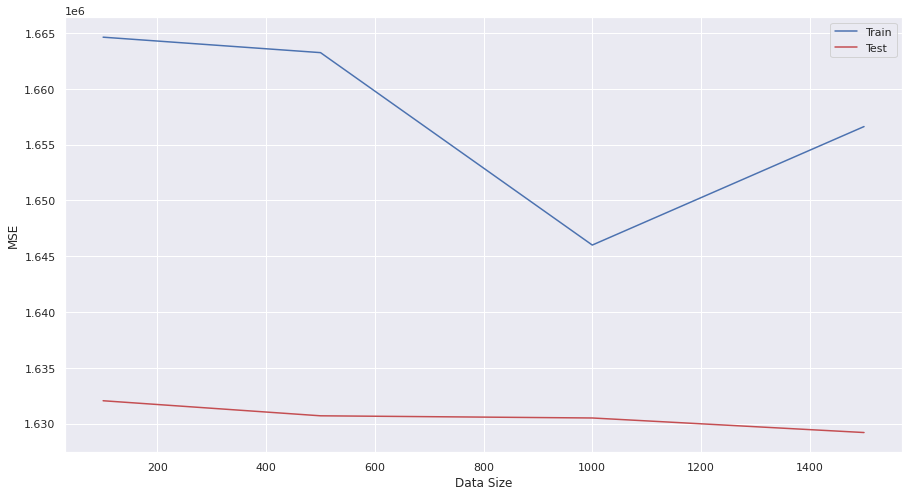

In [ ]:
# Learning Curve
mse_test = []
mse_train = []

for i in range(10000,50000,10000):
  model = LinearRegression( iterations = 500, learning_rate = 0.01)

  model.fit( X_train.iloc[:i, :], y_train.iloc[:i, :]['shares'] )
  Y_pred_train = model.predict( X_train.iloc[:i, :])
  Y_pred_test = model.predict( X_test)
  mse_test.append(mean_squared_error(y_test['shares'], Y_pred_test))
  mse_train.append(mean_squared_error(y_train.iloc[:i, :]['shares'], Y_pred_train))

xaxis = rates
# Plot a simple line chart
plt.plot(xaxis, mse_train, 'b', label = "Train")
# Plot another line on the same chart/graph
plt.plot(xaxis, mse_test, 'r', label = "Test")

plt.xlabel("Data Size")
plt.ylabel("MSE")
plt.legend()

In [ ]:
model = LinearRegression( iterations = 1000, learning_rate = 0.1)
start_time = timeit.default_timer()
model.fit( X_train, y_train['shares'] )
print('Training Time: ', timeit.default_timer() - start_time)
  
# Prediction on test set
Y_pred = model.predict( X_test)
  
lr_results = pd.DataFrame({'Predicted': np.round( Y_pred, 2 ), 'Real': y_test['shares']})

Training Time:  4.027919872000041


In [ ]:
print('RMSE', np.sqrt(mean_squared_error(lr_results['Predicted'], lr_results['Real'])))
print('MAE', mean_absolute_error(lr_results['Predicted'], lr_results['Real']))

RMSE 1276.3684731632459
MAE 1088.893203394058


In [ ]:
# using pca values

model = LinearRegression( iterations = 1000, learning_rate = 0.1)
model.fit( X_train_pca, y_train_pca['shares'] )
  
# Prediction on test set
Y_pred = model.predict( X_test_pca)
  
lr_results = pd.DataFrame({'Predicted': np.round( Y_pred, 2 ), 'Real': y_test_pca['shares']})

print('RMSE', np.sqrt(mean_squared_error(lr_results['Predicted'], lr_results['Real'])))
print('MAE', mean_absolute_error(lr_results['Predicted'], lr_results['Real']))


RMSE 1278.3746933265425
MAE 1091.3638500957256


# KNN

In [ ]:
# Function to return the list of distances of the test records from train records
def distNeighbours(X_train,Y_train,X_test,K):
    distance=[]
    for i in range(len(X_train)):
        eDistance=0
        for j in range(len(X_train.columns)):   
                eDistance+=round(np.sqrt(pow((X_train.iloc[i,j]-X_test[j]),2)),2)
        distance.append((eDistance,i,Y_train.iloc[i]))
        distance=sorted(distance, key=lambda x: x[0])[0:K]
    return distance

# Output is the mean of the K nearest neighbours
def predictOutputNumeric(X_train,Y_train,X_test,K):
    neighbours=[]
    responses=[]
    for i in range(len(X_test)):
        neighbours.append(distNeighbours(X_train,Y_train,X_test.iloc[i,:],K))
    for i in neighbours:
        mean=0
        for j in i:
            mean+=j[-1]
        mean=mean/K
        responses.append(mean)
    return responses

In [ ]:
# optimal k 
error_rate = []
error_rate_train = []
for i in range(3,50,20):
  print(i)
  o = predictOutputNumeric(X_train_knn,y_train_knn['shares'],X_test_knn,i)
  o_train = predictOutputNumeric(X_train_knn,y_train_knn['shares'],X_train_knn,i)
  error_rate.append(mean_squared_error(y_test_knn['shares'], o))
  error_rate_train.append(mean_squared_error(y_train_knn['shares'], o_train))

3
23
43


Text(0.5, 1.0, 'Learning Curve')

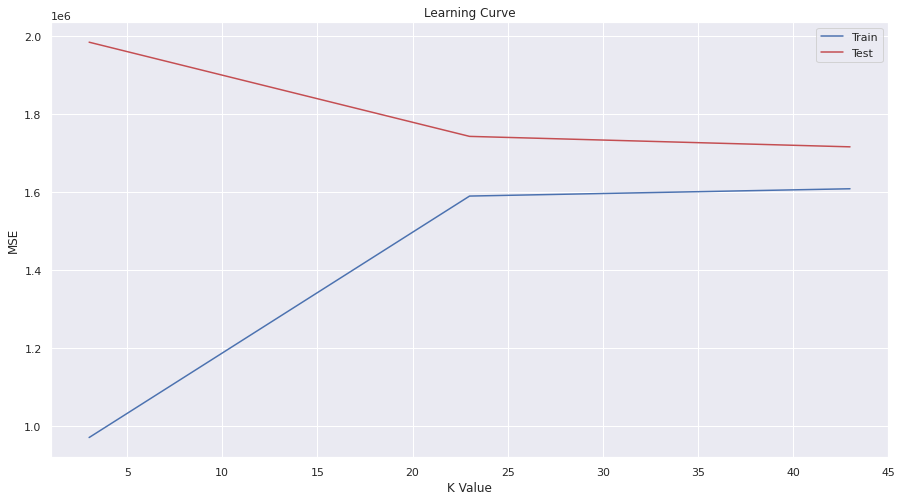

In [ ]:
# k = sns.lineplot(x= range(3,50,20), y=error_rate)
# k.set( xlabel = "K-value", ylabel = "MSE", xlim = (1,50))

xaxis = range(3,50,20)
# Plot a simple line chart
plt.plot(xaxis, error_rate_train, 'b', label = "Train")
# Plot another line on the same chart/graph
plt.plot(xaxis, error_rate, 'r', label = "Test")

plt.xlabel("K Value")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")



In [ ]:
start_time = timeit.default_timer()
# Predict
output=predictOutputNumeric(X_train_knn,y_train_knn['shares'],X_test_knn,23)
print('Training Time: ', timeit.default_timer() - start_time)

Training Time:  12.133719892999977


In [ ]:
print('RMSE', np.sqrt(mean_squared_error(y_test_knn['shares'], output)))
print('MAE', mean_absolute_error(y_test_knn['shares'], output))

RMSE 1320.2772539249636
MAE 1119.5771132852528


In [ ]:
# using pca values
sample_knn_pca = copy(X_pca)
sample_knn_pca['shares'] = Y_pca['shares']
sample_knn_pca['popularity'] = Y_pca['popularity']
sample_knn_pca = sample_knn_pca.groupby('popularity').sample(100, random_state=3)
X_train_sample_pca, X_test_sample_pca, y_train_sample_pca, y_test_sample_pca = train_test_split(sample_knn_pca.iloc[:,:-2], 
                                                                                sample_knn_pca[['shares','popularity']], 
                                                                                test_size = 0.25, random_state = 0 )

# Predict
output=predictOutputNumeric(X_train_sample_pca,y_train_sample_pca['shares'],X_test_sample_pca,23)

print('RMSE', np.sqrt(mean_squared_error(y_test_sample_pca['shares'], output)))
print('MAE', mean_absolute_error(y_test_sample_pca['shares'], output))



RMSE 1319.1135403829767
MAE 1158.5722391724273


# Decision Tree

In [174]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [175]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):

        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [176]:
mse_train= []
mse_test = []
for i in range(1,20,2):
  regressor = DecisionTreeRegressor(min_samples_split=3, max_depth= i )
  regressor.fit(np.array(X_train_sample),np.array(y_train_sample['shares']).reshape(-1,1))
  Y_pred = regressor.predict(np.array(X_test_sample))
  y_train_pred = regressor.predict(np.array(X_train_sample))
  print('Depth = ', i)
  mse_test.append(mean_squared_error(y_test_sample['shares'], Y_pred))
  mse_train.append(mean_squared_error(y_train_sample['shares'], y_train_pred))


Depth =  1
Depth =  3
Depth =  5
Depth =  7
Depth =  9
Depth =  11
Depth =  13
Depth =  15
Depth =  17
Depth =  19


Text(0.5, 1.0, 'Learning Curve')

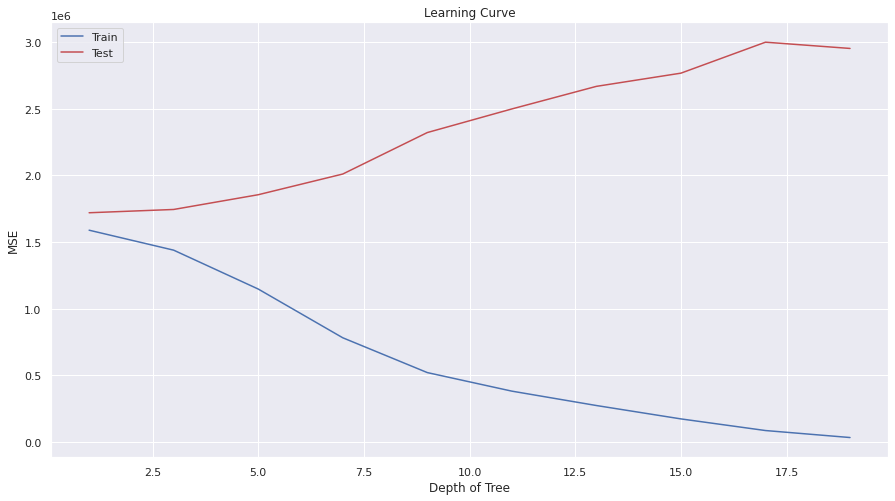

In [177]:
xaxis = range(1,20,2)
# Plot a simple line chart
plt.plot(xaxis, mse_train, 'b', label = "Train")
# Plot another line on the same chart/graph
plt.plot(xaxis, mse_test, 'r', label = "Test")

plt.xlabel("Depth of Tree")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")

In [178]:
start_time = timeit.default_timer()
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(np.array(X_train_sample),np.array(y_train_sample['shares']).reshape(-1,1))
regressor.print_tree()
print('Training Time: ', timeit.default_timer() - start_time)

X_0 <= 1.5569260189985004 ? 95289.86184649146
 left:X_14 <= 0.6428133166552542 ? 61977.408602659125
  left:X_14 <= 0.091501277433053 ? 57769.24686095584
    left:X_9 <= 1.9336284428361992 ? 73061.8678902802
        left:X_8 <= -0.6524243028751413 ? 53744.51363475993
                left:X_3 <= 2.369318003847819 ? 422751.12322693854
                                left:1520.0370046195303
                                right:5200.0
                right:X_4 <= -0.6811232777181236 ? 62640.520397877786
                                left:1797.2631497610994
                                right:2483.636891847511
        right:X_7 <= 0.04734098846698174 ? 450935.85862251814
                left:X_11 <= -0.5362232361656263 ? 480054.748783499
                                left:3848.9637226470295
                                right:2160.4039027111194
                right:X_3 <= 0.5805019631311954 ? 434393.82515678613
                                left:4042.2205307046047
               

In [179]:
Y_pred = regressor.predict(np.array(X_test_sample))

print('RMSE',np.sqrt(mean_squared_error(y_test_sample['shares'], Y_pred)))
print('MAE',mean_absolute_error(y_test_sample['shares'], Y_pred))

RMSE 1369.1351121138398
MAE 1132.0329085477254


In [180]:
# PCA
start_time = timeit.default_timer()
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit(np.array(X_train_sample_pca),np.array(y_train_sample_pca['shares']).reshape(-1,1))
regressor.print_tree()
print('Training Time: ', timeit.default_timer() - start_time)

Y_pred = regressor.predict(np.array(X_test_sample_pca))

print('RMSE',np.sqrt(mean_squared_error(y_test_sample_pca['shares'], Y_pred)))
print('MAE',mean_absolute_error(y_test_sample_pca['shares'], Y_pred))

X_9 <= 0.6522413760515207 ? 105574.50173298945
 left:X_7 <= 0.8480813375197307 ? 83837.9683280387
  left:X_11 <= -0.7022000515500251 ? 92105.73132152553
    left:X_8 <= -1.1819709947074095 ? 426475.86826555885
        left:X_0 <= -0.8020293094996908 ? 810000.0
                left:4600.0
                right:2800.0
        right:X_6 <= 0.0471640042485867 ? 101666.21506872942
                left:X_1 <= -1.2285498364644138 ? 33691.50340136056
                                left:744.6666666666666
                                right:1192.0
                right:X_11 <= -1.090239715980358 ? 92342.37377781628
                                left:1366.6666666666667
                                right:1994.3561823658558
    right:X_5 <= 0.9554055948065328 ? 129137.50972164469
        left:X_3 <= 0.6421852680922507 ? 91369.28957925574
                left:X_9 <= 0.2495174272358287 ? 163495.59566241782
                                left:2878.219823971399
                                

# Random Forest

In [181]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [182]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [183]:
class DecisionTree:

    def __init__(self, min_samples_split=10, max_depth=10000, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        
        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        # parent loss
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

In [184]:
def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    n_cols = X.shape[1]

    idxs = np.random.choice(n_samples, n_cols, replace=True)
    return X[idxs], y[idxs]

In [185]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [186]:
class RandomForest:
    
    def __init__(self, n_trees, min_samples_split=10,
                 max_depth=10000, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                max_depth=self.max_depth, n_feats=self.n_feats)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

Trees =  1
Trees =  11
Trees =  21
Trees =  31
Trees =  41
Trees =  51


Text(0.5, 1.0, 'Learning Curve')

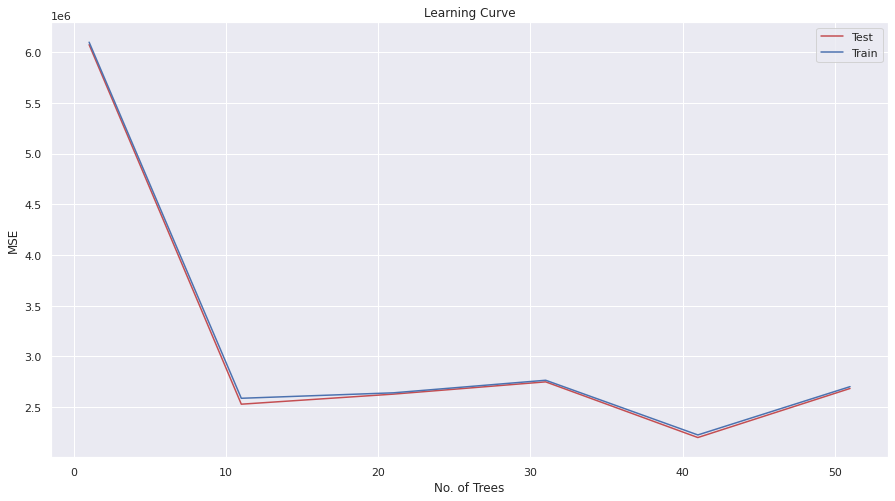

In [187]:
mse_test = []
mse_train = []
for i in range(1,52,10):

  RF_reg = RandomForest(n_trees = i, max_depth = 40)
  RF_reg.fit(X_train.to_numpy().astype(int), y_train['shares'].to_numpy().astype(int))

  y_pred = RF_reg.predict(X_test.to_numpy().astype(int))
  y_pred_train = RF_reg.predict(X_train.to_numpy().astype(int))
  print('Trees = ', i)
  mse_test.append(mean_squared_error(y_test['shares'], y_pred))
  mse_train.append(mean_squared_error(y_train['shares'], y_pred_train))

xaxis = range(1,52,10)
# Plot a simple line chart
plt.plot(xaxis, mse_test, 'r', label = "Test")
plt.plot(xaxis, mse_train, 'b', label = "Train")
plt.xlabel("No. of Trees")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")

In [188]:
start_time = timeit.default_timer()
RF_reg = RandomForest(n_trees = 10, max_depth = 40)
RF_reg.fit(X_train.to_numpy().astype(int), y_train['shares'].to_numpy().astype(int))
print('Training Time: ', timeit.default_timer() - start_time)

Training Time:  1.9729910329988343


In [189]:
y_pred = RF_reg.predict(X_test.to_numpy().astype(int))

print('RMSE', np.sqrt(mean_squared_error(y_test['shares'], y_pred)))
print('MAE', mean_absolute_error(y_test['shares'], y_pred))

RMSE 1565.0533017017513
MAE 1203.603010075354


In [190]:
RF_reg = RandomForest(n_trees = 10, max_depth = 40)
RF_reg.fit(X_train_pca.to_numpy().astype(int), y_train_pca['shares'].to_numpy().astype(int))

y_pred = RF_reg.predict(X_test_pca.to_numpy().astype(int))

print('RMSE', np.sqrt(mean_squared_error(y_test_pca['shares'], y_pred)))
print('MAE', mean_absolute_error(y_test_pca['shares'], y_pred))

RMSE 2105.1352669025887
MAE 1684.6147497124796


# Neural Networks

In [ ]:
# Set the input shape
input_shape = (15,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(64, input_shape=input_shape, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])

Feature shape: (15,)


In [ ]:
mse_test = []
mse_train = []
for i in range(50,250,50):
  model.fit(X_train_sample, y_train_sample['shares'], epochs=i, batch_size=20, verbose=0, validation_split=0.2)
  Y_pred = model.predict(X_test_sample)
  Y_pred_train = model.predict( X_train_sample)
  mse_train.append(mean_squared_error(y_train_sample['shares'], Y_pred_train))
  mse_test.append(mean_squared_error(y_test_sample['shares'], Y_pred))
  print(i)

50
100
150
200


Text(0.5, 1.0, 'Learning Curve')

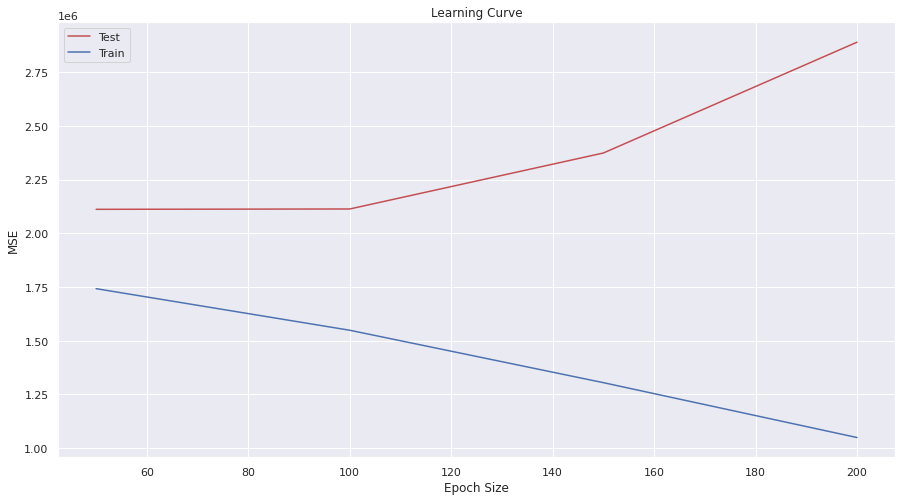

In [ ]:
xaxis = range(50,250,50)
# Plot a simple line chart
plt.plot(xaxis, mse_test, 'r', label = "Test")
plt.plot(xaxis, mse_train, 'b', label = "Train")
plt.xlabel("Epoch Size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")

In [ ]:
start_time = timeit.default_timer()
model.fit(X_train, y_train['shares'], epochs=100, batch_size=20, verbose=2, validation_split=0.2)
print('Training Time: ', timeit.default_timer() - start_time)

Epoch 1/100
1665/1665 - 3s - loss: 1203.9099 - mean_squared_error: 2395622.7500 - val_loss: 1098.8872 - val_mean_squared_error: 1929616.0000 - 3s/epoch - 2ms/step
Epoch 2/100
1665/1665 - 2s - loss: 1076.3696 - mean_squared_error: 1871233.2500 - val_loss: 1080.3929 - val_mean_squared_error: 1886859.1250 - 2s/epoch - 1ms/step
Epoch 3/100
1665/1665 - 3s - loss: 1063.6522 - mean_squared_error: 1823904.7500 - val_loss: 1071.2444 - val_mean_squared_error: 1859767.3750 - 3s/epoch - 2ms/step
Epoch 4/100
1665/1665 - 4s - loss: 1059.0607 - mean_squared_error: 1814303.3750 - val_loss: 1067.6682 - val_mean_squared_error: 1850777.1250 - 4s/epoch - 3ms/step
Epoch 5/100
1665/1665 - 4s - loss: 1056.3247 - mean_squared_error: 1803814.8750 - val_loss: 1065.1407 - val_mean_squared_error: 1804967.2500 - 4s/epoch - 2ms/step
Epoch 6/100
1665/1665 - 3s - loss: 1052.3379 - mean_squared_error: 1787362.3750 - val_loss: 1063.0317 - val_mean_squared_error: 1810535.1250 - 3s/epoch - 2ms/step
Epoch 7/100
1665/1665 

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print('RMSE', np.sqrt(mean_squared_error(y_test['shares'], y_pred)))
print('MAE', mean_absolute_error(y_test['shares'], y_pred))

RMSE 1296.097150851351
MAE 981.5765213058355
